## Define model Classes

### Load libraries

In [ ]:
!pip install pydot
!pip install graphviz

In [2]:
import warnings
warnings.filterwarnings("ignore")

import math
from scipy.special import logsumexp
import numpy as np

import keras
from keras.regularizers import l2
from keras import Input
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Dense
from keras import Model
from keras.models import load_model
from keras.layers import Bidirectional
from tensorflow.keras.utils import get_custom_objects

import time

In [3]:
import tensorflow as tf

### LSTM (Unidirectional)

This is the original implementation as used in the paper

we rename the model from "net" to "UniLSTM"

In [4]:
class UniLSTM:
    def __init__(self):
        pass

    def train(self, X_train, X_train_ctx, y_train, regression, loss, n_epochs = 100,
        normalize = False, y_normalize=False, tau = 1.0, dropout = 0.05, batch_size= 128, context=True, num_folds=10, model_name='predictor', checkpoint_dir='./checkpoints/'):

        """
            Constructor for the class implementing a Bayesian neural network
            trained with the probabilistic back propagation method.
            @param X_train      Matrix with the features for the training data.
            @param y_train      Vector with the target variables for the
                                training data.
            @param n_epochs     Numer of epochs for which to train the
                                network. The recommended value 40 should be
                                enough.
            @param normalize    Whether to normalize the input features. This
                                is recommended unles the input vector is for
                                example formed by binary features (a
                                fingerprint). In that case we do not recommend
                                to normalize the features.
            @param tau          Tau value used for regularization
            @param dropout      Dropout rate for all the dropout layers in the
                                network.
        """

        # We normalize the training data to have zero mean and unit standard
        # deviation in the training set if necessary
        """
        if normalize:
            self.std_X_train_ctx = np.std(X_train_ctx, 0)
            self.std_X_train_ctx[ self.X_train_ctx == 0 ] = 1
            self.mean_X_train_ctx = np.mean(X_train_ctx, 0)
        else:
            self.std_X_train_ctx = np.ones(X_train_ctx.shape[ 1 ])
            self.mean_X_train_ctx = np.zeros(X_train_ctx.shape[ 1 ])

        X_train_ctx = (X_train_ctx - np.full(X_train_ctx.shape, self.mean_X_train_ctx)) / \
            np.full(X_train_ctx.shape, self.std_X_train_ctx)
        """
        if y_normalize:
            self.mean_y_train = np.mean(y_train)
            self.std_y_train = np.std(y_train)

            y_train_normalized = (y_train - self.mean_y_train) / self.std_y_train
            y_train_normalized = np.array(y_train_normalized, ndmin = 2).T
        else:
            if len(y_train.shape)==1:
                y_train_normalized = np.array(y_train, ndmin = 2).T
            else:
                y_train_normalized = y_train


        # We construct the network
        N = X_train.shape[0]
        batch_size = batch_size
        num_folds = num_folds

        inputs = Input(shape=(X_train.shape[1], X_train.shape[2]), name='main_input')
        inter = Dropout(dropout)(inputs, training=True)
        inter = LSTM(30, recurrent_dropout=dropout, return_sequences=True)(inputs, training=True)
        inter = Dropout(dropout)(inter, training=True)
        inter = LSTM(30)(inter, training=True)
        inter = Dropout(dropout)(inter, training=True)

        if context==True:
            context_shape = X_train_ctx.shape
            auxiliary_input = Input(shape=(context_shape[1],), name='aux_input')
            aux_inter = Dropout(dropout)(auxiliary_input, training=True)

            inter = keras.layers.concatenate([inter, aux_inter])
            inter = Dropout(dropout)(inter, training=True)

            if regression:
                outputs = Dense(y_train_normalized.shape[1], )(inter)
            else:
                outputs = Dense(y_train_normalized.shape[1], activation='softmax')(inter)
            model = Model(inputs=[inputs,auxiliary_input], outputs=outputs)

            model.compile(loss=loss, optimizer='adam')
            early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
            model_checkpoint = keras.callbacks.ModelCheckpoint('%smodel_%s_.h5' % (checkpoint_dir, model_name), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
            lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
            # We iterate the learning process
            start_time = time.time()
            model.fit([X_train,X_train_ctx], y_train_normalized, batch_size=batch_size, epochs=n_epochs, verbose=2, validation_split=1/num_folds, callbacks=[early_stopping, model_checkpoint, lr_reducer])
        else:
            if regression:
                outputs = Dense(y_train_normalized.shape[1], )(inter)
            else:
                outputs = Dense(y_train_normalized.shape[1], activation='softmax')(inter)
            model = Model(inputs=inputs, outputs=outputs)

            model.compile(loss=loss, optimizer='adam')
            early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
            model_checkpoint = keras.callbacks.ModelCheckpoint('%smodel_%s_.h5' % (checkpoint_dir, model_name), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
            lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
            # We iterate the learning process
            start_time = time.time()
            model.fit(X_train, y_train_normalized, batch_size=batch_size, epochs=n_epochs, verbose=2, validation_split=1/num_folds, callbacks=[early_stopping, model_checkpoint, lr_reducer])

        self.model = model
        self.tau = tau
        self.running_time = time.time() - start_time

        # We are done!

    def load(self, checkpoint_dir, model_name, loss, compiles):
        if not compiles:
            model = load_model('%smodel_%s_.h5' % (checkpoint_dir, model_name), compile=compiles)
            model.compile(loss=loss, optimizer='adam')
        else:
            model = load_model('%smodel_%s_.h5' % (checkpoint_dir, model_name))
        self.model = model

    def predict(self, X_test, X_test_ctx=None, context=True):

        """
            Function for making predictions with the Bayesian neural network.
            @param X_test   The matrix of features for the test data


            @return m       The predictive mean for the test target variables.
            @return v       The predictive variance for the test target
                            variables.
            @return v_noise The estimated variance for the additive noise.
        """

        X_test = np.array(X_test, ndmin = 3)


        # We normalize the test set
        #X_test_ctx = (X_test_ctx - np.full(X_test_ctx.shape, self.mean_X_train_ctx)) /    np.full(X_test_ctx.shape, self.std_X_train_ctx)

        # We compute the predictive mean and variance for the target variables
        # of the test data

        model = self.model
        """
        standard_pred = model.predict([X_test, X_test_ctx], batch_size=500, verbose=1)
        standard_pred = standard_pred * self.std_y_train + self.mean_y_train
        rmse_standard_pred = np.mean((y_test.squeeze() - standard_pred.squeeze())**2.)**0.5
        """
        T = 10
        #if context==True:
        X_test_ctx = np.array(X_test_ctx, ndmin=2)
        Yt_hat = np.array([model.predict([X_test, X_test_ctx], batch_size=1, verbose=0) for _ in range(T)])
        #else:
        #    Yt_hat = np.array([model.predict(X_test, batch_size=1, verbose=0) for _ in range(T)])
        #Yt_hat = Yt_hat * self.std_y_train + self.mean_y_train
        regression=False
        if regression:
            MC_pred = np.mean(Yt_hat, 0)
            MC_uncertainty = np.std(Yt_hat, 0)
        else:
            MC_pred = np.mean(Yt_hat, 0)
            MC_uncertainty = list()
            for i in range(Yt_hat.shape[2]):
                MC_uncertainty.append(np.std(Yt_hat[:,:,i].squeeze(),0))
        #rmse = np.mean((y_test.squeeze() - MC_pred.squeeze())**2.)**0.5

        # We compute the test log-likelihood
        """
        ll = (logsumexp(-0.5 * self.tau * (y_test[None] - Yt_hat)**2., 0) - np.log(T)
            - 0.5*np.log(2*np.pi) + 0.5*np.log(self.tau))
        test_ll = np.mean(ll)
        """
        # We are done!
        return MC_pred, MC_uncertainty

### Bi-directional LSTM

The code for this is based on the original code, I have only changed the part where models are described.
Also, a bug was fixed in model.save and model.load as well as in predict function (for with contextual information part)

We name the model "BiLSTM" here.

In [5]:
class BiLSTM:
    def __init__(self):
        pass

    def train(self, X_train, X_train_ctx, y_train, regression, loss, n_epochs=100,
              normalize=False, y_normalize=False, tau=1.0, dropout=0.05, batch_size=128, context=True,
              num_folds=10, model_name='predictor', checkpoint_dir='./checkpoints/'):

        if y_normalize:
            self.mean_y_train = np.mean(y_train)
            self.std_y_train = np.std(y_train)

            y_train_normalized = (y_train - self.mean_y_train) / self.std_y_train
            y_train_normalized = np.array(y_train_normalized, ndmin=2).T
        else:
            if len(y_train.shape) == 1:
                y_train_normalized = np.array(y_train, ndmin=2).T
            else:
                y_train_normalized = y_train

        # We construct the network
        N = X_train.shape[0]
        batch_size = batch_size
        num_folds = num_folds

        inputs = Input(shape=(X_train.shape[1], X_train.shape[2]), name='main_input')
        inter = Dropout(dropout)(inputs, training=True)
        inter = Bidirectional(LSTM(64, recurrent_dropout=dropout, return_sequences=True))(inter, training=True)
        inter = Dropout(dropout)(inter, training=True)
        inter = Bidirectional(LSTM(64))(inter, training=True)
        inter = Dropout(dropout)(inter, training=True)

        if context == True:
            context_shape = X_train_ctx.shape
            auxiliary_input = Input(shape=(context_shape[1],), name='aux_input')
            aux_inter = Dropout(dropout)(auxiliary_input, training=True)

            inter = keras.layers.concatenate([inter, aux_inter])
            inter = Dropout(dropout)(inter, training=True)

            if regression:
                outputs = Dense(y_train_normalized.shape[1])(inter)
            else:
                outputs = Dense(y_train_normalized.shape[1], activation='softmax')(inter)
            model = Model(inputs=[inputs, auxiliary_input], outputs=outputs)

            model.compile(loss=loss, optimizer='adam')
            early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
            model_checkpoint = keras.callbacks.ModelCheckpoint('%smodel_%s_.h5' % (checkpoint_dir, model_name),
                                                               monitor='val_loss', verbose=0, save_best_only=True,
                                                               save_weights_only=False, mode='auto')
            lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0,
                                                            mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
            # We iterate the learning process
            start_time = time.time()
            model.fit([X_train, X_train_ctx], y_train_normalized, batch_size=batch_size, epochs=n_epochs,
                      verbose=2, validation_split=1 / num_folds, callbacks=[early_stopping, model_checkpoint, lr_reducer])
        else:
            if regression:
                outputs = Dense(y_train_normalized.shape[1])(inter)
            else:
                outputs = Dense(y_train_normalized.shape[1], activation='softmax')(inter)
            model = Model(inputs=inputs, outputs=outputs)

            model.compile(loss=loss, optimizer='adam')
            early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
            model_checkpoint = keras.callbacks.ModelCheckpoint('%smodel_%s_.h5' % (checkpoint_dir, model_name),
                                                               monitor='val_loss', verbose=0, save_best_only=True,
                                                               save_weights_only=False, mode='auto')
            lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0,
                                                            mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
            # We iterate the learning process
            start_time = time.time()
            model.fit(X_train, y_train_normalized, batch_size=batch_size, epochs=n_epochs,
                      verbose=2, validation_split=1 / num_folds, callbacks=[early_stopping, model_checkpoint, lr_reducer])

        self.model = model
        self.tau = tau
        self.running_time = time.time() - start_time

        # We are done!

    def load(self, checkpoint_dir, model_name, loss, compiles):
        if not compiles:
            model = load_model('%smodel_%s_.h5' % (checkpoint_dir, model_name), compile=compiles)
            model.compile(loss=loss, optimizer='adam')
        else:
            model = load_model('%smodel_%s_.h5' % (checkpoint_dir, model_name))
        self.model = model

    def predict(self, X_test, X_test_ctx=None, context=True):
        X_test = np.array(X_test, ndmin=3)

        model = self.model

        T = 10
        #if context==True:
        X_test_ctx = np.array(X_test_ctx, ndmin=2)
        Yt_hat = np.array([model.predict([X_test, X_test_ctx], batch_size=1, verbose=0) for _ in range(T)])
        # if context == True:
        #     X_test_ctx = np.array(X_test_ctx, ndmin=2)
        #     Yt_hat = np.array([model.predict([X_test, X_test_ctx], batch_size=1, verbose=0) for _ in range(T)])
        # else:
        #     Yt_hat = np.array([model.predict(X_test, batch_size=1, verbose=0) for _ in range(T)])
        # Yt_hat = Yt_hat * self.std_y_train + self.mean_y_train
        regression = False
        if regression:
            MC_pred = np.mean(Yt_hat, 0)
            MC_uncertainty = np.std(Yt_hat, 0)
        else:
            MC_pred = np.mean(Yt_hat, 0)
            MC_uncertainty = list()
            for i in range(Yt_hat.shape[2]):
                MC_uncertainty.append(np.std(Yt_hat[:, :, i].squeeze(), 0))

        return MC_pred, MC_uncertainty



### GRUs

In [6]:
from tensorflow.keras.layers import GRU

class GRUModel:
    def __init__(self):
        pass

    def train(self, X_train, X_train_ctx, y_train, regression, loss, n_epochs=100,
              normalize=False, y_normalize=False, tau=1.0, dropout=0.05, batch_size=128,
              context=True, num_folds=10, model_name='predictor', checkpoint_dir='./checkpoints/'):

        if y_normalize:
            self.mean_y_train = np.mean(y_train)
            self.std_y_train = np.std(y_train)

            y_train_normalized = (y_train - self.mean_y_train) / self.std_y_train
            y_train_normalized = np.array(y_train_normalized, ndmin=2).T
        else:
            if len(y_train.shape) == 1:
                y_train_normalized = np.array(y_train, ndmin=2).T
            else:
                y_train_normalized = y_train

        # We construct the network
        N = X_train.shape[0]
        batch_size = batch_size
        num_folds = num_folds

        inputs = Input(shape=(X_train.shape[1], X_train.shape[2]), name='main_input')
        inter = Dropout(dropout)(inputs, training=True)
        inter = GRU(30, dropout=dropout, recurrent_dropout=dropout, return_sequences=True)(inter, training=True)
        inter = GRU(30, dropout=dropout, recurrent_dropout=dropout)(inter, training=True)
        inter = Dropout(dropout)(inter, training=True)

        if context == True:
            context_shape = X_train_ctx.shape
            auxiliary_input = Input(shape=(context_shape[1],), name='aux_input')
            aux_inter = Dropout(dropout)(auxiliary_input, training=True)

            inter = keras.layers.concatenate([inter, aux_inter])
            inter = Dropout(dropout)(inter, training=True)

            if regression:
                outputs = Dense(y_train_normalized.shape[1], )(inter)
            else:
                outputs = Dense(y_train_normalized.shape[1], activation='softmax')(inter)
            model = Model(inputs=[inputs, auxiliary_input], outputs=outputs)

            model.compile(loss=loss, optimizer='adam')
            early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
            model_checkpoint = keras.callbacks.ModelCheckpoint(
                '%smodel_%s_.h5' % (checkpoint_dir, model_name), monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=False, mode='auto')
            lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0,
                                                           mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
            # We iterate the learning process
            start_time = time.time()
            model.fit([X_train, X_train_ctx], y_train_normalized, batch_size=batch_size, epochs=n_epochs, verbose=2,
                      validation_split=1 / num_folds, callbacks=[early_stopping, model_checkpoint, lr_reducer])
        else:
            if regression:
                outputs = Dense(y_train_normalized.shape[1], )(inter)
            else:
                outputs = Dense(y_train_normalized.shape[1], activation='softmax')(inter)
            model = Model(inputs=inputs, outputs=outputs)

            model.compile(loss=loss, optimizer='adam')
            early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
            model_checkpoint = keras.callbacks.ModelCheckpoint(
                '%smodel_%s_.h5' % (checkpoint_dir, model_name), monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=False, mode='auto')
            lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0,
                                                           mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
            # We iterate the learning process
            start_time = time.time()
            model.fit(X_train, y_train_normalized, batch_size=batch_size, epochs=n_epochs, verbose=2,
                      validation_split=1 / num_folds, callbacks=[early_stopping, model_checkpoint, lr_reducer])

        self.model = model
        self.tau = tau
        self.running_time = time.time() - start_time

        # We are done!

    def load(self, checkpoint_dir, model_name, loss, compiles):
        if not compiles:
            model = load_model('%smodel_%s_.h5' % (checkpoint_dir, model_name), compile=compiles)
            model.compile(loss=loss, optimizer='adam')
        else:
            model = load_model('%smodel_%s_.h5' % (checkpoint_dir, model_name))
        self.model = model

    def predict(self, X_test, X_test_ctx=None, context=True):
        X_test = np.array(X_test, ndmin=3)

        model = self.model

        T = 10
        # if context==True:
        X_test_ctx = np.array(X_test_ctx, ndmin=2)
        Yt_hat = np.array([model.predict([X_test, X_test_ctx], batch_size=1, verbose=0) for _ in range(T)])
        # else:
        #    Yt_hat = np.array([model.predict(X_test, batch_size=1, verbose=0) for _ in range(T)])
        # Yt_hat = Yt_hat * self.std_y_train + self.mean_y_train
        regression = False
        if regression:
            MC_pred = np.mean(Yt_hat, 0)
            MC_uncertainty = np.std(Yt_hat, 0)
        else:
            MC_pred = np.mean(Yt_hat, 0)
            MC_uncertainty = list()
            for i in range(Yt_hat.shape[2]):
                MC_uncertainty.append(np.std(Yt_hat[:, :, i].squeeze(), 0))
        return MC_pred, MC_uncertainty

### CNN Model

In [7]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

class CNNModel:
    def __init__(self):
        pass

    def train(self, X_train, X_train_ctx, y_train, regression, loss, n_epochs=100,
              normalize=False, y_normalize=False, tau=1.0, dropout=0.05, batch_size=128,
              context=True, num_folds=10, model_name='predictor', checkpoint_dir='./checkpoints/'):

        if y_normalize:
            self.mean_y_train = np.mean(y_train)
            self.std_y_train = np.std(y_train)

            y_train_normalized = (y_train - self.mean_y_train) / self.std_y_train
            y_train_normalized = np.array(y_train_normalized, ndmin=2).T
        else:
            if len(y_train.shape) == 1:
                y_train_normalized = np.array(y_train, ndmin=2).T
            else:
                y_train_normalized = y_train

        # We construct the network
        N = X_train.shape[0]
        batch_size = batch_size
        num_folds = num_folds

        inputs = Input(shape=(X_train.shape[1], X_train.shape[2]), name='main_input')
        inter = Dropout(dropout)(inputs, training=True)
        inter = Conv1D(30, kernel_size=3, activation='relu')(inter)
        inter = MaxPooling1D(pool_size=2)(inter)
        inter = Conv1D(30, kernel_size=3, activation='relu')(inter)
        inter = MaxPooling1D(pool_size=2)(inter)
        inter = Flatten()(inter)
        inter = Dropout(dropout)(inter, training=True)

        if context == True:
            context_shape = X_train_ctx.shape
            auxiliary_input = Input(shape=(context_shape[1],), name='aux_input')
            aux_inter = Dropout(dropout)(auxiliary_input, training=True)

            inter = keras.layers.concatenate([inter, aux_inter])
            inter = Dropout(dropout)(inter, training=True)

            if regression:
                outputs = Dense(y_train_normalized.shape[1], )(inter)
            else:
                outputs = Dense(y_train_normalized.shape[1], activation='softmax')(inter)
            model = Model(inputs=[inputs, auxiliary_input], outputs=outputs)

            optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
            model.compile(loss=loss, optimizer=optimizer)
            early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
            model_checkpoint = keras.callbacks.ModelCheckpoint(
                '%smodel_%s_.h5' % (checkpoint_dir, model_name), monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=False, mode='auto')
            lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0,
                                                           mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
            # We iterate the learning process
            start_time = time.time()
            model.fit([X_train, X_train_ctx], y_train_normalized, batch_size=batch_size, epochs=n_epochs, verbose=2,
                      validation_split=1 / num_folds, callbacks=[early_stopping, model_checkpoint, lr_reducer])
        else:
            if regression:
                outputs = Dense(y_train_normalized.shape[1], )(inter)
            else:
                outputs = Dense(y_train_normalized.shape[1], activation='softmax')(inter)
            model = Model(inputs=inputs, outputs=outputs)

            optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
            model.compile(loss=loss, optimizer=optimizer)
            
            early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
            model_checkpoint = keras.callbacks.ModelCheckpoint(
                '%smodel_%s_.h5' % (checkpoint_dir, model_name), monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=False, mode='auto')
            lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0,
                                                           mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.01)
            # We iterate the learning process
            start_time = time.time()
            model.fit(X_train, y_train_normalized, batch_size=batch_size, epochs=n_epochs, verbose=2,
                      validation_split=1 / num_folds, callbacks=[early_stopping, model_checkpoint, lr_reducer])

        self.model = model
        self.tau = tau
        self.running_time = time.time() - start_time

        # We are done!

    def load(self, checkpoint_dir, model_name, loss, compiles):
        if not compiles:
            model = load_model('%smodel_%s_.h5' % (checkpoint_dir, model_name), compile=compiles)
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
            model.compile(loss=loss, optimizer=optimizer)
        else:
            model = load_model('%smodel_%s_.h5' % (checkpoint_dir, model_name))
        self.model = model

    def predict(self, X_test, X_test_ctx=None, context=True):
        X_test = np.array(X_test, ndmin=3)

        model = self.model

        T = 10
        # if context==True:
        X_test_ctx = np.array(X_test_ctx, ndmin=2)
        Yt_hat = np.array([model.predict([X_test, X_test_ctx], batch_size=1, verbose=0) for _ in range(T)])
        # else:
        #    Yt_hat = np.array([model.predict(X_test, batch_size=1, verbose=0) for _ in range(T)])
        # Yt_hat = Yt_hat * self.std_y_train + self.mean_y_train
        regression = False
        if regression:
            MC_pred = np.mean(Yt_hat, 0)
            MC_uncertainty = np.std(Yt_hat, 0)
        else:
            MC_pred = np.mean(Yt_hat, 0)
            MC_uncertainty = list()
            for i in range(Yt_hat.shape[2]):
                MC_uncertainty.append(np.std(Yt_hat[:, :, i].squeeze(), 0))
        return MC_pred, MC_uncertainty


### Transformer based model

We name the model "TransformerModel" here.

In [ ]:


import numpy as np
import time
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Transformer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate
        })
        return config

# Register the custom Transformer layer
get_custom_objects().update({"Transformer": Transformer})

class TransformerModel:
    def __init__(self):
        pass

    def train(self, X_train, X_train_ctx, y_train, regression, loss, n_epochs=100,
              normalize=False, y_normalize=False, tau=1.0, dropout=0.05, batch_size=128, context=True,
              num_folds=10, model_name='predictor', checkpoint_dir='./checkpoints/'):

        if y_normalize:
            self.mean_y_train = np.mean(y_train)
            self.std_y_train = np.std(y_train)

            y_train_normalized = (y_train - self.mean_y_train) / self.std_y_train
            y_train_normalized = np.array(y_train_normalized, ndmin=2).T
        else:
            if len(y_train.shape) == 1:
                y_train_normalized = np.array(y_train, ndmin=2).T
            else:
                y_train_normalized = y_train

        # We construct the network
        N = X_train.shape[0]
        batch_size = batch_size
        num_folds = num_folds

        inputs = Input(shape=(X_train.shape[1], X_train.shape[2]), name='main_input')
        inter = Dropout(dropout)(inputs, training=True)
        inter = Transformer(embed_dim=X_train.shape[2], num_heads=6, ff_dim=64, rate=dropout)(inter, training=True)
        inter = Dropout(dropout)(inter, training=True)

        if context:
            context_shape = X_train_ctx.shape
            auxiliary_input = Input(shape=(context_shape[1],), name='aux_input')
            aux_inter = Dropout(dropout)(auxiliary_input, training=True)
            aux_inter = tf.expand_dims(aux_inter, axis=1)
            aux_inter = tf.tile(aux_inter, [1, X_train.shape[1], 1])  # Reshape to match sequence length
            inter = tf.concat([inter, aux_inter], axis=-1)
            inter = Dropout(dropout)(inter, training=True)

            if regression:
                outputs = Dense(y_train_normalized.shape[1])(inter)
            else:
                outputs = Dense(y_train_normalized.shape[1], activation='softmax')(inter)
            model = Model(inputs=[inputs, auxiliary_input], outputs=outputs)

            model.compile(loss=loss, optimizer='adam')
            early_stopping = EarlyStopping(monitor='val_loss', patience=10)
            model_checkpoint = ModelCheckpoint('%smodel_%s_.h5' % (checkpoint_dir, model_name),
                                               monitor='val_loss', verbose=0, save_best_only=True,
                                               save_weights_only=False, mode='auto')
            lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0,
                                            mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
            # We iterate the learning process
            start_time = time.time()
            model.fit([X_train, X_train_ctx], y_train_normalized, batch_size=batch_size, epochs=n_epochs,
                      verbose=2, validation_split=1 / num_folds, callbacks=[early_stopping, model_checkpoint, lr_reducer])
        else:
            if regression:
                outputs = Dense(y_train_normalized.shape[1])(inter)
            else:
                outputs = Dense(y_train_normalized.shape[1], activation='softmax')(inter)
            model = Model(inputs=inputs, outputs=outputs)

            model.compile(loss=loss, optimizer='adam')
            early_stopping = EarlyStopping(monitor='val_loss', patience=10)
            model_checkpoint = ModelCheckpoint('%smodel_%s_.h5' % (checkpoint_dir, model_name),
                                               monitor='val_loss', verbose=0, save_best_only=True,
                                               save_weights_only=False, mode='auto')
            lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0,
                                            mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
            # We iterate the learning process
            start_time = time.time()
            model.fit(X_train, y_train_normalized, batch_size=batch_size, epochs=n_epochs,
                      verbose=2, validation_split=1 / num_folds, callbacks=[early_stopping, model_checkpoint, lr_reducer])

        self.model = model
        self.tau = tau
        self.running_time = time.time() - start_time

    def load(self, checkpoint_dir, model_name, loss, compiles):
        if not compiles:
            model = load_model('%smodel_%s_.h5' % (checkpoint_dir, model_name), compile=compiles)
            model.compile(loss=loss, optimizer='adam')
        else:
            model = load_model('%smodel_%s_.h5' % (checkpoint_dir, model_name))
        self.model = model


    def predict(self, X_test, X_test_ctx=None, context=True):
        X_test = np.array(X_test, ndmin=3)

        model = self.model

        T = 10
#        if context == True:
        X_test_ctx = np.array(X_test_ctx, ndmin=2)
        Yt_hat = np.array([model.predict([X_test, X_test_ctx], batch_size=1, verbose=0) for _ in range(T)])
#        else:
#            Yt_hat = np.array([model.predict(X_test, batch_size=1, verbose=0) for _ in range(T)])

        regression = False
        if regression:
            MC_pred = np.mean(Yt_hat, 0)
            MC_uncertainty = np.std(Yt_hat, 0)
        else:
            MC_pred = np.mean(Yt_hat, 0)
            MC_uncertainty = list()
            for i in range(Yt_hat.shape[2]):
                MC_uncertainty.append(np.std(Yt_hat[:, :, i].squeeze(), 0))

        return MC_pred, MC_uncertainty


## Train Model on data

### Install and load libraries

In [ ]:
from feature_generator import FeatureGenerator

import keras
import pickle
from datetime import datetime
import os
import argparse

### Define variables (parameters) for training

In [ ]:
accuracy_values = list()
accuracy_sum = 0.0
accuracy_value = 0.0
precision_values = list()
precision_sum = 0.0
precision_value = 0.0
recall_values = list()
recall_sum = 0.0
recall_value = 0.0
f1_values = list()
f1_sum = 0.0
f1_value = 0.0
training_time_seconds = list()

In [ ]:
task = "next_timestamp"
contextual_info= True
inter_case_level='Level1'

# dnn
num_epochs=20
learning_rate=0.002
num_folds=10
batch_size_train=256
batch_size_test=1

# data
data_set = "modi_BPI_2012_dropna_filter_act.csv"
data_dir = "../sample_data/real/"
checkpoint_dir = "./estimation/"

In [ ]:
level = inter_case_level

filename = data_dir + data_set
model_name = data_set + task + '_gru'

contextual_info = contextual_info
if task == 'next_activity':
    loss = 'categorical_crossentropy'
    regression = False
elif task == 'next_timestamp':
    loss = 'mae'
    regression = True

batch_size = batch_size_train
num_folds = num_folds

### Load and process data

In [ ]:


# load data
FG = FeatureGenerator()
df = FG.create_initial_log(filename)


In [ ]:
#split train and test
#train_df, test_df = FG.train_test_split(df, 0.7, 0.3)
train_df = df
test_df = train_df
#create train
train_df = FG.order_csv_time(train_df)
train_df = FG.queue_level(train_df)
train_df.to_csv('./training_data.csv')
state_list = FG.get_states(train_df)
train_X, train_Y_Event, train_Y_Time = FG.one_hot_encode_history(train_df, checkpoint_dir+data_set)

### Train Model

In [ ]:

if contextual_info:
    train_context_X = FG.generate_context_feature(train_df,state_list)
    model = GRUModel()
    if regression:
        model.train(train_X, train_context_X, train_Y_Time, regression, loss, batch_size=batch_size, num_folds=num_folds, model_name=model_name, checkpoint_dir=checkpoint_dir)
    else:
        model.train(train_X, train_context_X, train_Y_Event, regression, loss, batch_size=batch_size, num_folds=num_folds, model_name=model_name, checkpoint_dir=checkpoint_dir)
else:
    model_name += '_no_context_'
    train_context_X = None
    model = GRUModel()
    if regression:
        model.train(train_X, train_context_X, train_Y_Time, regression, loss, batch_size=batch_size, num_folds=num_folds, model_name=model_name, checkpoint_dir=checkpoint_dir, context=contextual_info)
    else:
        model.train(train_X, train_context_X, train_Y_Event, regression, loss, batch_size=batch_size, num_folds=num_folds, model_name=model_name, checkpoint_dir=checkpoint_dir, context=contextual_info)


In [ ]:
test_X, test_Y_Event, test_Y_Time = train_X, train_Y_Event, train_Y_Time
test_context_X = train_context_X
test_X = test_X[500]
test_context_X = test_context_X[500]
test_Y_Event = test_Y_Event[500]
MC_pred, MC_uncertainty = model.predict(test_X, test_context_X, test_Y_Event)

In [ ]:
MC_pred, MC_uncertainty

### Plotting Models

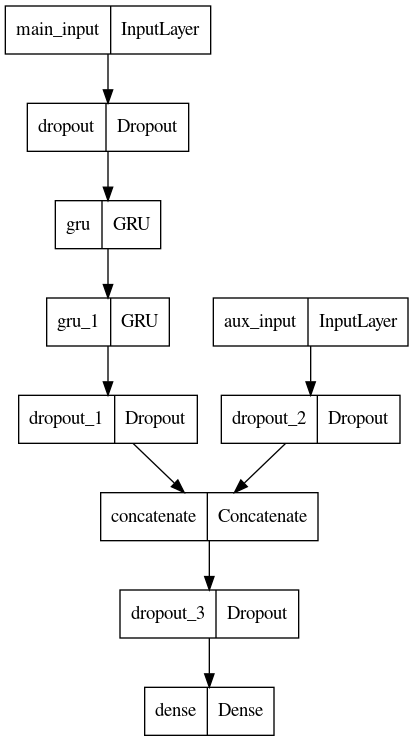

In [23]:
model = GRUModel()
loss = 'categorical_crossentropy'
compiles = False
model.load('./checkpoints/', 'modi_BPI_2012_dropna_filter_act.csvnext_activity_gru', loss, compiles)

tf.keras.utils.plot_model(model.model)

In [24]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 20, 55)]     0           []                               
                                                                                                  
 dropout (Dropout)              (None, 20, 55)       0           ['main_input[0][0]']             
                                                                                                  
 gru (GRU)                      (None, 20, 30)       7830        ['dropout[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 30)           5580        ['gru[0][0]']                    
                                                                                              